# Precapillary pulmonary hypertension: diagnostic disagreement between Fick and thermodilution for the measurement of cardiac output

In [45]:
import pandas as pd
import numpy as np

In [46]:
# define limits of agreement, as well as lower and upper bounds of cardiac output
LoA = 2
CO_lower_bound = 1.3
CO_upper_bound = 10.2

In [47]:
mPAP = 22
PAWP = 10
COtd = 4

In [48]:
def PVR_calc(mPAP, PAWP, CO):
    # transpulmonary pressure gradient
    TPG = mPAP - PAWP
    PVR = TPG/CO
    return PVR

In [49]:
PVR_calc(mPAP, PAWP, COtd)

3.0

In [50]:
def meets_PcPH_criteria(mPAP, PAWP, CO, PVR_limit=3):
    PVR = PVR_calc(mPAP, PAWP, CO)
    if PVR >= PVR_limit:
        return True
    else:
        return False

In [51]:
meets_PcPH_criteria(mPAP, PAWP, COtd)

True

## Probability of diagnostic disagreement

Goal: compute probability of diagnostic disagreement (DD+ & DD-) given limits of CO
- where Ir is the probability that the CO is within the pre-specified limits [ar, br]

P(DD|Ir) = P(DD ∩ Ir) / P(Ir)



### Computation of P(DD ∩ Ir)

P(DD+ ∩ Ir)=P(COm − br ≤ X ≤ min(COm − TPG/3, COm − ar)

P(DD− ∩ Ir)=P(max(COm − TPG/3, COm − br) ≤ X ≤ COm − ar)

Nomenclature: *Proba numérateur* (ODS)

In [52]:
from scipy.stats import norm

def P_DD_and_Ir(mPAP, PAWP, COm, ar, br, LoA, PVR_limit=3):
    """
    Compute P(DD ∩ Ir), where Ir is the probability that the CO is within the pre-specified limits [ar, br]
    :param mPAP: 
    :param PAWP: 
    :param COm: 
    :param ar: lower bound of CO
    :param br: upper bound of CO
    :return: 
    """
    
    # delta to lower and upper bounds of interval
    delta_COm_lower_bound = COm - ar
    delta_COm_upper_bound = COm - br
    
    TPG = mPAP - PAWP
    PVR_over_limit = COm - TPG/PVR_limit
    
    # compute lower and upper bounds of probability of P(DD ∩ Ir)
    if meets_PcPH_criteria(mPAP, PAWP, COm, PVR_limit=PVR_limit):
        # bounds for P(DD+ ∩ Ir)
        lower_bound = delta_COm_upper_bound
        upper_bound = min(delta_COm_lower_bound, PVR_over_limit)
    else:
        # bounds for P(DD- ∩ Ir)
        lower_bound = max(delta_COm_upper_bound, PVR_over_limit)
        upper_bound = delta_COm_lower_bound
        
    # cumulative distribution function of normal distribution of lower and upper bounds
    P_lower_bound = norm.cdf(lower_bound, loc=0, scale=LoA/1.96)
    P_upper_bound = norm.cdf(upper_bound, loc=0, scale=LoA/1.96)
    
    # compute P(DD ∩ Ir)
    if upper_bound > lower_bound:
        P_DD_and_Ir = P_upper_bound - P_lower_bound
    else:
        P_DD_and_Ir = 0
        
    return P_DD_and_Ir    
    

In [53]:
P_DD_and_Ir(mPAP, PAWP, COm=COtd, ar=CO_lower_bound, br=CO_upper_bound, LoA=LoA)

0.49999999938391293

### Computation of P(Ir)

P(Ir) = P(COm − br ≤ X ≤ COm − ar)

Nomenclature: *Proba dénominateur* (ODS)

In [54]:
def P_Ir(COm, ar, br, LoA):
    """
    Compute P(Ir), where Ir is the probability that the CO is within the pre-specified limits [ar, br]
    :param COm: 
    :param ar: lower bound of CO
    :param br: upper bound of CO
    :return: 
    """
    # delta to lower and upper bounds of interval
    delta_COm_lower_bound = COm - ar
    delta_COm_upper_bound = COm - br
    
    # cumulative distribution function of normal distribution of lower and upper bounds
    P_lower_bound = norm.cdf(delta_COm_upper_bound, loc=0, scale=LoA/1.96)
    P_upper_bound = norm.cdf(delta_COm_lower_bound, loc=0, scale=LoA/1.96)
    
    # compute P(Ir)
    if delta_COm_lower_bound > delta_COm_upper_bound:
        P_Ir = P_upper_bound - P_lower_bound
    else:
        P_Ir = 0
        
    return P_Ir

In [55]:
P_Ir(COm=COtd, ar=CO_lower_bound, br=CO_upper_bound, LoA=LoA)

0.9959275085605617

### Computation of P(DD|Ir) 

In [56]:
def P_DD_plus_given_Ir(mPAP, PAWP, COm, ar, br, LoA, PVR_limit=3):
    """
    Compute P(DD+|Ir), where Ir is the probability that the CO is within the pre-specified limits [ar, br]
    :param mPAP: 
    :param PAWP: 
    :param COm: 
    :param ar: lower bound of CO
    :param br: upper bound of CO
    :return: 
    """
    P_DD_and_Ir_value = P_DD_and_Ir(mPAP, PAWP, COm, ar, br, LoA, PVR_limit)
    P_Ir_value = P_Ir(COm, ar, br, LoA)
    
    # only valid if PcPH criteria are met
    if meets_PcPH_criteria(mPAP, PAWP, COm, PVR_limit=PVR_limit):
        P_DD_plus_given_Ir = P_DD_and_Ir_value / P_Ir_value
    else:
        P_DD_plus_given_Ir = 0
        
    return P_DD_plus_given_Ir

In [57]:
def P_DD_minus_given_Ir(mPAP, PAWP, COm, ar, br, LoA, PVR_limit=3):
    """
    Compute P(DD-|Ir), where Ir is the probability that the CO is within the pre-specified limits [ar, br]
    :param mPAP: 
    :param PAWP: 
    :param COm: 
    :param ar: lower bound of CO
    :param br: upper bound of CO
    :return: 
    """
    # if input not nan
    if np.isnan(mPAP) or np.isnan(PAWP) or np.isnan(COm):
        return np.nan
    
    P_DD_and_Ir_value = P_DD_and_Ir(mPAP, PAWP, COm, ar, br, LoA, PVR_limit)
    P_Ir_value = P_Ir(COm, ar, br, LoA)
    
    # only valid if PcPH criteria are not met
    if not meets_PcPH_criteria(mPAP, PAWP, COm, PVR_limit=PVR_limit):
        P_DD_minus_given_Ir = P_DD_and_Ir_value / P_Ir_value
    else:
        P_DD_minus_given_Ir = 0
        
    return P_DD_minus_given_Ir

In [58]:
P_DD_plus_given_Ir(mPAP, PAWP, COm=COtd, ar=CO_lower_bound, br=CO_upper_bound, LoA=LoA), P_DD_minus_given_Ir(mPAP, PAWP, COm=COtd, ar=CO_lower_bound, br=CO_upper_bound, LoA=LoA)


(0.5020445716039866, 0)

## Verify consistency of results

In [59]:
original_computation_data_path = '/Users/jk1/Library/CloudStorage/OneDrive-unige.ch/icu_research/co_method/ProbabilityOfDD.ods'

In [60]:
original_computation_data = pd.read_excel(original_computation_data_path, sheet_name='DD with conditions new formula', header=8, index_col=0)

In [61]:
original_computation_data.head()

,mPAP,PAWP,COm,PVRm,Unnamed: 5,fit with previous formula,Unnamed: 7,PcPH,DD+ (%),DD- (%),...,lower bound,upper bound,Unnamed: 18,Loi normale lower,Loi normale upper,difference,Unnamed: 22,loi normale lower,loi normale upper,difference.1
Patient,,,,,,,,,,,,,,,,,,,,,
NaN,20.0,15.0,1.0,5.000000,NaN,YES,NaN,yes,100.000000,0.0,...,-11.000000,-1.0,NaN,2.133036e-103,0.024998,0.024998,NaN,2.133036e-103,0.024998,0.024998
NaN,20.0,15.0,2.0,2.500000,NaN,YES,NaN,no,0.000000,0.0,...,0.333333,0.0,NaN,7.432293e-01,0.500000,0.000000,NaN,7.731196e-86,0.500000,0.500000
NaN,22.0,10.0,4.0,3.000000,NaN,YES,NaN,yes,50.002214,0.0,...,-8.000000,0.0,NaN,1.036271e-55,0.500000,0.500000,NaN,1.036271e-55,0.999956,0.999956
NaN,22.0,10.0,3.8,3.157895,NaN,YES,NaN,yes,34.760188,0.0,...,-8.200000,-0.2,NaN,2.004694e-58,0.347529,0.347529,NaN,2.004694e-58,0.999791,0.999791
NaN,22.0,10.0,3.6,3.333333,NaN,YES,NaN,yes,21.670563,0.0,...,-8.400000,-0.4,NaN,3.327669e-61,0.216520,0.216520,NaN,3.327669e-61,0.999144,0.999144


In [62]:
original_computation_data['recomputed_DD+'] = original_computation_data.apply(lambda row: P_DD_plus_given_Ir(row['mPAP'], row['PAWP'], row['COm '], CO_lower_bound, CO_upper_bound, LoA), axis=1)
original_computation_data['delta_DD+'] = original_computation_data['DD+ (%)'] - original_computation_data['recomputed_DD+'] * 100

In [63]:
original_computation_data[['DD+ (%)', 'recomputed_DD+', 'delta_DD+']]

,DD+ (%),recomputed_DD+,delta_DD+
Patient,,,
NaN,100.000000,0.668014,33.198552
NaN,0.000000,0.000000,0.000000
NaN,50.002214,0.502045,-0.202243
NaN,34.760188,0.425343,-7.774135
NaN,21.670563,0.351785,-13.507940
NaN,12.016210,0.283886,-16.372358
NaN,5.899133,0.223516,-16.452513
NaN,2.563881,0.171763,-14.612426
NaN,0.991588,0.128923,-11.900682


In [64]:
original_computation_data['recomputed_DD-'] = original_computation_data.apply(lambda row: P_DD_minus_given_Ir(row['mPAP'], row['PAWP'], row['COm '], CO_lower_bound, CO_upper_bound, LoA), axis=1)
original_computation_data['delta_DD-'] = original_computation_data['DD- (%)'] - original_computation_data['recomputed_DD-'] * 100

In [65]:
original_computation_data[['DD- (%)', 'recomputed_DD-', 'delta_DD-']]

,DD- (%),recomputed_DD-,delta_DD-
Patient,,,
NaN,0.000000,0.000000,0.000000
NaN,0.000000,0.166662,-16.666164
NaN,0.000000,0.000000,0.000000
NaN,0.000000,0.000000,0.000000
NaN,0.000000,0.000000,0.000000
NaN,0.000000,0.000000,0.000000
NaN,0.000000,0.000000,0.000000
NaN,0.000000,0.000000,0.000000
NaN,0.000000,0.000000,0.000000


In [66]:
original_computation_data

,mPAP,PAWP,COm,PVRm,Unnamed: 5,fit with previous formula,Unnamed: 7,PcPH,DD+ (%),DD- (%),...,Loi normale upper,difference,Unnamed: 22,loi normale lower,loi normale upper,difference.1,recomputed_DD+,delta_DD+,recomputed_DD-,delta_DD-
Patient,,,,,,,,,,,,,,,,,,,,,
NaN,20.0,15.0,1.0,5.000000,NaN,YES,NaN,yes,100.000000,0.000000,...,0.024998,0.024998,NaN,2.133036e-103,0.024998,0.024998,0.668014,33.198552,0.000000,0.000000
NaN,20.0,15.0,2.0,2.500000,NaN,YES,NaN,no,0.000000,0.000000,...,0.500000,0.000000,NaN,7.731196e-86,0.500000,0.500000,0.000000,0.000000,0.166662,-16.666164
NaN,22.0,10.0,4.0,3.000000,NaN,YES,NaN,yes,50.002214,0.000000,...,0.500000,0.500000,NaN,1.036271e-55,0.999956,0.999956,0.502045,-0.202243,0.000000,0.000000
NaN,22.0,10.0,3.8,3.157895,NaN,YES,NaN,yes,34.760188,0.000000,...,0.347529,0.347529,NaN,2.004694e-58,0.999791,0.999791,0.425343,-7.774135,0.000000,0.000000
NaN,22.0,10.0,3.6,3.333333,NaN,YES,NaN,yes,21.670563,0.000000,...,0.216520,0.216520,NaN,3.327669e-61,0.999144,0.999144,0.351785,-13.507940,0.000000,0.000000
NaN,22.0,10.0,3.4,3.529412,NaN,YES,NaN,yes,12.016210,0.000000,...,0.119797,0.119797,NaN,4.739557e-64,0.996965,0.996965,0.283886,-16.372358,0.000000,0.000000
NaN,22.0,10.0,3.2,3.750000,NaN,YES,NaN,yes,5.899133,0.000000,...,0.058441,0.058441,NaN,5.792019e-67,0.990664,0.990664,0.223516,-16.452513,0.000000,0.000000
NaN,22.0,10.0,3.0,4.000000,NaN,YES,NaN,yes,2.563881,0.000000,...,0.024998,0.024998,NaN,6.073048e-70,0.975002,0.975002,0.171763,-14.612426,0.000000,0.000000
NaN,22.0,10.0,2.8,4.285714,NaN,YES,NaN,yes,0.991588,0.000000,...,0.009336,0.009336,NaN,5.463344e-73,0.941559,0.941559,0.128923,-11.900682,0.000000,0.000000


In [67]:
P_DD_minus_given_Ir(23, 15, 6, CO_lower_bound, CO_upper_bound, LoA, PVR_limit=2)

0.02499637582041468

In [68]:
P_DD_plus_given_Ir(21, 15, 2.5, CO_lower_bound, CO_upper_bound, LoA, PVR_limit=2)

0.3545399239903967

In [83]:
P_DD_plus_given_Ir(21, 15, 5, 2, 12, LoA, PVR_limit=2)

0

In [84]:
P_DD_minus_given_Ir(21, 15, 5, 2, 12, LoA, PVR_limit=2)

0.023395226914097095

In [76]:
CO_upper_bound, CO_lower_bound

(10.2, 1.3)

### For a given set of PAWP and mPAP, compute the probability of DD+ and DD- for a range of COm

In [69]:
COm_range = np.arange(2, 12, 0.01)

In [70]:
DD_given_Ir = pd.DataFrame(index=COm_range, columns=['DD+ (%)', 'DD- (%)'])
DD_given_Ir.index.name = 'COm'
DD_given_Ir['PWR'] = DD_given_Ir.apply(lambda row: PVR_calc(mPAP, PAWP, row.name), axis=1)
DD_given_Ir['DD+'] = DD_given_Ir.apply(lambda row: P_DD_plus_given_Ir(mPAP, PAWP, row.name, CO_lower_bound, CO_upper_bound, LoA), axis=1)
DD_given_Ir['DD-'] = DD_given_Ir.apply(lambda row: P_DD_minus_given_Ir(mPAP, PAWP, row.name, CO_lower_bound, CO_upper_bound, LoA), axis=1)

In [71]:
DD_given_Ir

,DD+ (%),DD- (%),PWR,DD+,DD-
COm,,,,,
2.00,NaN,NaN,6.000000,0.033169,0.000000e+00
2.01,NaN,NaN,5.970149,0.033799,0.000000e+00
2.02,NaN,NaN,5.940594,0.034438,0.000000e+00
2.03,NaN,NaN,5.911330,0.035089,0.000000e+00
2.04,NaN,NaN,5.882353,0.035750,0.000000e+00
...,...,...,...,...,...
11.95,NaN,NaN,1.004184,0.000000,7.714773e-14
11.96,NaN,NaN,1.003344,0.000000,7.352164e-14
11.97,NaN,NaN,1.002506,0.000000,6.971432e-14


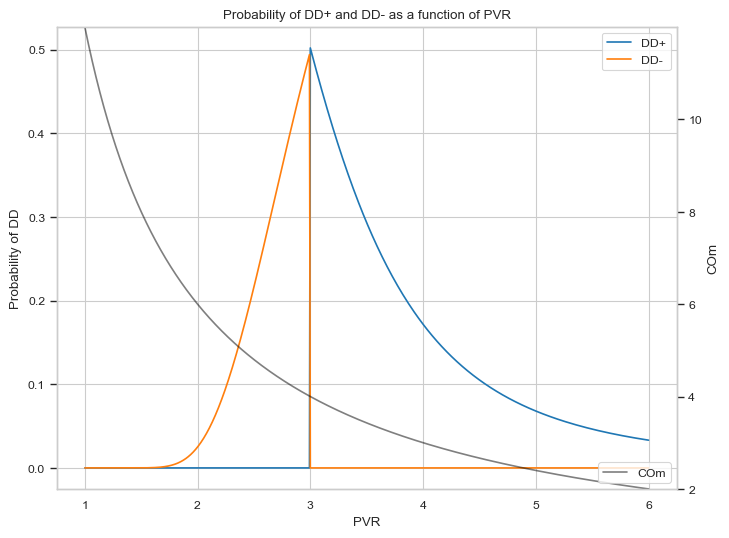

In [72]:
# plot probability of DD+ and DD- as a function of PVR
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x='PWR', y='DD+', data=DD_given_Ir, ax=ax, label='DD+')
sns.lineplot(x='PWR', y='DD-', data=DD_given_Ir, ax=ax, label='DD-')
ax.set_xlabel('PVR')
ax.set_ylabel('Probability of DD')
ax.set_title('Probability of DD+ and DD- as a function of PVR')

# set a second x axis with COm
ax2 = ax.twinx()
sns.lineplot(x='PWR', y='COm', data=DD_given_Ir, ax=ax2, color='black', label='COm', alpha=0.5)
ax2.set_ylabel('COm')
ax2.set_ylim(2, 12)
ax2.set_yticks(np.arange(2, 12, 2))
ax2.grid(False)
ax2.legend(loc='lower right')

plt.show()


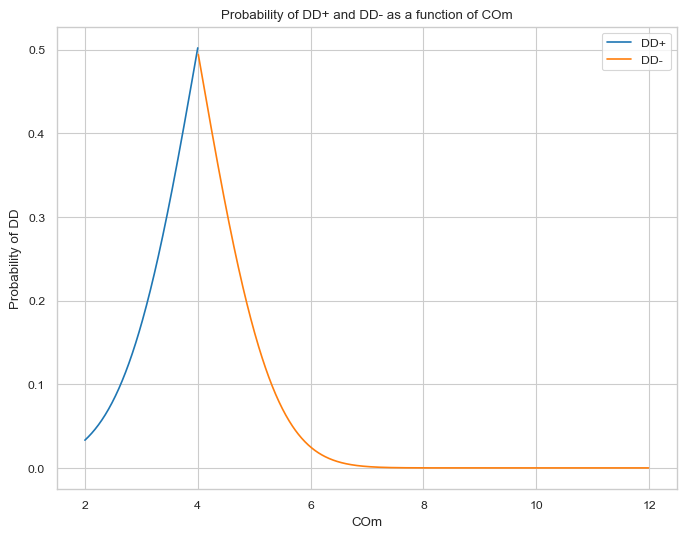

In [73]:
# plot probability of DD+ and DD- as a function of COm
sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(x='COm', y='DD+', data=DD_given_Ir[DD_given_Ir['DD+']>0], ax=ax, label='DD+')
sns.lineplot(x='COm', y='DD-', data=DD_given_Ir[DD_given_Ir['DD-']>0], ax=ax, label='DD-')
# sns.lineplot(x='COm', y='PWR', data=DD_given_Ir, ax=ax, color='black', label='PVR', alpha=0.5)
ax.set_xlabel('COm')
ax.set_ylabel('Probability of DD')
ax.set_title('Probability of DD+ and DD- as a function of COm')

plt.show()

<Axes: xlabel='COm'>

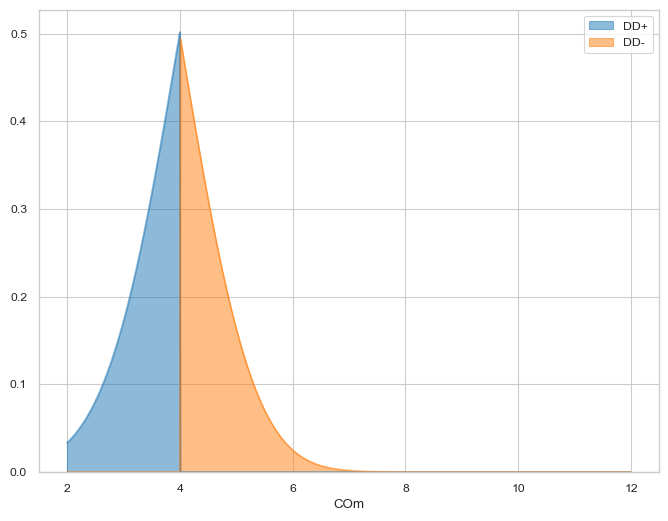

In [74]:
DD_given_Ir.plot.area(y=['DD+', 'DD-'], stacked=False, figsize=(8, 6))